In [23]:
# importing os module 
import os
#import the pandas library and aliasing as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [24]:
# This functions as whether the user wants to save data. It uses recursion to force the user to give a valid answer
def yesno(question):
    """Simple Yes/No Function."""
    prompt = f'{question} ? (y/n): '
    ans = input(prompt).strip().lower()
    if ans not in ['y', 'n']:
        print(f'{ans} is invalid, please try again...')
        return yesno(question)
    if ans == 'y':
        return True
    return False

In [25]:
# This function generates the rmsdpp, rmsdpe, and energy data for plotting
def GenerateData(fname, path):
    rmsdpp_file = open(path + '/rmsdpp.dat', "x")
    with open(fname, 'r') as f:
        for line in f.readlines():
            if 'RMSDPP' in line:
                rmsdpp_file.write(str(line.split()[-1]) + '\n')
    rmsdpp_file.close()


    rmsdpe_file = open(path + '/rmsdpe.dat', "x")
    with open(fname, 'r') as f:
        for line in f.readlines():
            if 'RMSDPE' in line:
                rmsdpe_file.write(str(line.split()[-1]) + '\n')
    rmsdpe_file.close()


    energy_file = open(path + '/energy.dat', "x")
    with open(fname, 'r') as f:
        for line in f.readlines():
            if ('smt' in fname):
                if ('The Energy for This Iteration is:' in line):
                    energy_file.write(str(line.split()[6]) + '\n')
            else:
                if 'SubSCF Loop, Total Energy = ' in line:
                    energy_file.write(str(line.split()[7]) + '\n')
    energy_file.close()

In [26]:
# This function reads the log file, extract key information and puts it in the dataframe
def fillDF(log_file,df):
    temp = log_file.split("/")[-1][:-4].split('_')

    index = log_file.split("/")[-1][:-4].replace('_smt','').replace('_stw','')

    Alg = temp[1]

    # if the algorithm is simultaneous, we fill in the structure, basis information, and # of smt iterations
    if (Alg == 'smt'):
        df.loc[index]['Structure'] = temp[0]
        df.loc[index]['EBasis'] = temp[2]
        df.loc[index]['PBasis'] = temp[3]

        with open(log_file, 'r') as f:
            for line in f.readlines():
                if 'NBasis=' in line:     
                    df.loc[index]['NEBasis'] = int(line.split()[1])
                    break

        with open(log_file, 'r') as f:
            for line in f.readlines():
                if 'NEO NBasis=' in line:     
                    df.loc[index]['NPBasis'] = int(line.split()[2])
                    break

        E_SMT = 0.00
        with open(log_file, 'r') as f:
            for line in f.readlines():
                if 'NEO-SCF Converged After Iteration #' in line:     
                    df.loc[index]['NSMT'] = int(line.split()[5])
                if ('The Energy for This Iteration is:' in line):
                    E_SMT = float(line.split()[6])
        df.loc[index]['E-SMT'] =  E_SMT        
                    
                    
    # if the algorithm is stepwise, we fill in the # of sub-scf iterations
    if (Alg == 'stw'):

        Elec_Iter = 0
        Prot_Iter = 0
        E_STW = 0.00
        
        with open(log_file, 'r') as f:
            for line in f.readlines():
                if 'Electronic Converged after Iteration #' in line:     
                    Elec_Iter += int(line.split()[5])
                if 'Protonic Converged after Iteration #' in line:     
                    Prot_Iter += int(line.split()[5])
                if ('SubSCF Loop, Total Energy = ' in line):
                    E_STW = float(line.split()[7])

        df.loc[index]['NSTW-E'] = Elec_Iter
        df.loc[index]['NSTW-P'] = Prot_Iter
        df.loc[index]['E-STW'] =  E_STW       

In [27]:
# This function calculates the theoretical computational cost based on # of fock builds and basis size
def getCompCost(NEFock,NPFock,NEBasis,NPBasis):
    return NEFock*np.power(NEBasis,4) + NPFock*np.power(NPBasis,4) + (NEFock+NPFock)*np.power(NEBasis,2)*np.power(NPBasis,2)

In [28]:
# Main code starts here

output_dir = '/Users/aodongliu/LiGroup/gaussian/neo_scf_data_processing/OutputFiles'
data_dir = '/Users/aodongliu/LiGroup/gaussian/neo_scf_data_processing/Data/'


full_path_log_files = []

for subdir, dirs, files in os.walk(output_dir):
    for file in files:
        if file.endswith(".log"):
            full_name = os.path.join(subdir, file)
            full_path_log_files .insert(0,full_name)      
#            name_without_path = full_name.split("/")[-1] 
#            log_files.insert(0,name_without_path)        

In [29]:
saveData = yesno("Do you want to save the data")
print(f'you answer was: {saveData}')

Do you want to save the data ? (y/n): y
you answer was: True


In [31]:
if (saveData):
    for log_file in full_path_log_files:
        destination_dir = log_file.split("/")[-1][:-4]
        path = os.path.join(data_dir, destination_dir)
        os.mkdir(path)
        GenerateData(log_file,path)

In [9]:
structures = ['eigen','ring','zundel']
elec_basis_pool = ['3-21g','6-31g','4-31g','6-311g','6-311g(d,p)','cc-pvdz','cc-pvtz','cc-pvqz','def2svp','def2tzvp','def2qzvp']
prot_basis_pool = ['protsp','pb4d','pb4f1','pb4f2','pb5d']

In [10]:
Calculations = []
for structure in structures:
    for prot_basis in prot_basis_pool:                                          
        for elec_basis in elec_basis_pool: 
            elec_basis = elec_basis.replace('-', '').replace('(', '').replace(')', '').replace(',', '')
            prot_basis = prot_basis.replace('-', '').replace('(', '').replace(')', '').replace(',', '')
            temp = structure + '_' + elec_basis + '_' + prot_basis
            Calculations.append(temp)

In [11]:
df = pd.DataFrame(columns=['Structure',
                          'EBasis',
                          'PBasis',
                          'NEBasis',
                          'NPBasis',
                          'NSMT',
                          'NSTW-E',
                          'NSTW-P',
                          'E-SMT',
                          'E-STW',
                           'E-Diff',
                           'Basis Ratio',
                           'Cost Ratio'
                          ],index= Calculations)
df

,Structure,EBasis,PBasis,NEBasis,NPBasis,NSMT,NSTW-E,NSTW-P,E-SMT,E-STW,E-Diff,Basis Ratio,Cost Ratio
eigen_321g_protsp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eigen_631g_protsp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eigen_431g_protsp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eigen_6311g_protsp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eigen_6311gdp_protsp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
zundel_ccpvtz_pb5d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zundel_ccpvqz_pb5d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zundel_def2svp_pb5d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zundel_def2tzvp_pb5d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
for log_file in full_path_log_files:
    fillDF(log_file,df)
df

,Structure,EBasis,PBasis,NEBasis,NPBasis,NSMT,NSTW-E,NSTW-P,E-SMT,E-STW,E-Diff,Basis Ratio,Cost Ratio
eigen_321g_protsp,eigen,321g,protsp,54,36,43,53,93,-302.233047,-302.233047,NaN,NaN,NaN
eigen_631g_protsp,eigen,631g,protsp,54,36,43,54,95,-303.741055,-303.741055,NaN,NaN,NaN
eigen_431g_protsp,eigen,431g,protsp,54,36,42,54,95,-303.444775,-303.444775,NaN,NaN,NaN
eigen_6311g_protsp,eigen,6311g,protsp,79,36,45,53,108,-303.843703,-303.843703,NaN,NaN,NaN
eigen_6311gdp_protsp,eigen,6311gdp,protsp,126,36,90,162,356,-303.906127,-303.906127,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
zundel_ccpvtz_pb5d,zundel,ccpvtz,pb5d,246,288,174,90,570,-304.266498,-304.266498,NaN,NaN,NaN
zundel_ccpvqz_pb5d,zundel,ccpvqz,pb5d,490,288,232,141,815,-304.293603,-304.293603,NaN,NaN,NaN
zundel_def2svp_pb5d,zundel,def2svp,pb5d,101,288,158,86,525,-303.914389,-303.914389,NaN,NaN,NaN
zundel_def2tzvp_pb5d,zundel,def2tzvp,pb5d,178,288,158,75,509,-304.274568,-304.274568,NaN,NaN,NaN


In [14]:
# Do some post processing to get the energy difference, computational cost, and cost ratio
df['E-Diff'] = df['E-SMT'] - df['E-STW'] 
df['Cost Ratio'] = getCompCost(df['NSMT'],df['NSMT'],df['NEBasis'],df['NPBasis'])  / getCompCost(df['NSTW-E'],df['NSTW-P'],df['NEBasis'],df['NPBasis'])
df['Basis Ratio'] = df['NPBasis'] / df['NEBasis']

# Prints in a pretty manner
df.style.format({'E-Diff': "{:.2E}",'E-STW': "{:.2f}",'E-SMT': "{:.2f}",'Basis Ratio': "{:.2f}",'Cost Ratio': "{:.2f}"})

,Structure,EBasis,PBasis,NEBasis,NPBasis,NSMT,NSTW-E,NSTW-P,E-SMT,E-STW,E-Diff,Basis Ratio,Cost Ratio
eigen_321g_protsp,eigen,321g,protsp,54,36,43,53,93,-302.23,-302.23,-1.71E-12,0.67,0.66
eigen_631g_protsp,eigen,631g,protsp,54,36,43,54,95,-303.74,-303.74,-1.48E-12,0.67,0.65
eigen_431g_protsp,eigen,431g,protsp,54,36,42,54,95,-303.44,-303.44,-3.98E-13,0.67,0.63
eigen_6311g_protsp,eigen,6311g,protsp,79,36,45,53,108,-303.84,-303.84,-4.15E-12,0.46,0.72
eigen_6311gdp_protsp,eigen,6311gdp,protsp,126,36,90,162,356,-303.91,-303.91,-1.23E-10,0.29,0.51
eigen_ccpvdz_protsp,eigen,ccpvdz,protsp,101,36,78,157,355,-303.85,-303.85,-1.29E-10,0.36,0.43
eigen_ccpvtz_protsp,eigen,ccpvtz,protsp,246,36,126,332,814,-303.94,-303.94,-5.85E-10,0.15,0.37
eigen_ccpvqz_protsp,eigen,ccpvqz,protsp,490,36,179,606,1507,-303.99,-303.99,-1.23E-09,0.07,0.29
eigen_def2svp_protsp,eigen,def2svp,protsp,101,36,98,171,391,-303.59,-303.59,-1.37E-10,0.36,0.50
eigen_def2tzvp_protsp,eigen,def2tzvp,protsp,178,36,88,156,361,-303.96,-303.96,-1.51E-10,0.20,0.54


In [17]:
df['Cost Ratio'].max()

89.7595875652846

In [18]:
df.drop(['zundel_ccpvdz_protsp'], axis=0, inplace=True) 
df.drop(['zundel_def2svp_protsp'], axis=0, inplace=True) 

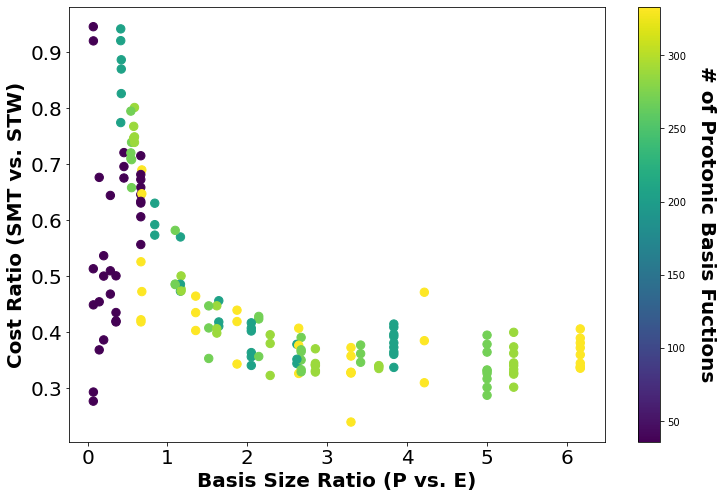

In [22]:
plt.figure(figsize = (12,8))
plt.scatter(df['Basis Ratio'],df['Cost Ratio'],c=df['NPBasis'],s=70)
plt.xlabel('Basis Size Ratio (P vs. E)',size=20,weight='bold')
plt.ylabel('Cost Ratio (SMT vs. STW)',size=20,weight='bold')
plt.xticks(size=20)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.set_label('# of Protonic Basis Fuctions',size=20, weight='bold', labelpad=30, rotation=270)
plt.savefig('/Users/aodongliu/LiGroup/gaussian/neo_scf_data_processing/plots/cost_vs_basissize_4h2o.pdf', dpi=600)
plt.show()